# Data
- Lead scoring dataset from UCI
    - https://archive.ics.uci.edu/dataset/222/bank+marketing

# Methods
- Feature Engineering
    - One hot encoded categorical features
    - Used SMOTE oversampling to generate more training samples for the minority class
    - Features are binned using Chi-square tests
    - Information value (IV) calculated for the bins
    - Features with an IV over 0.1 are selected
- Model
    - Logistic regression trained on the data with the bins used as features
    - Scoring system created with a range of 0 to 100
    - Feature bins are assigned points, where more points are associated with a lead more likely to convert

In [33]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning, BinningProcess, Scorecard
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
from optbinning.scorecard import plot_auc_roc
import seaborn as sns

In [34]:
df = pd.read_csv("data/raw/bank-additional/bank-additional-full.csv", delimiter=";")

In [35]:
df = df.drop(columns=["duration", "previous", "poutcome"])

In [36]:
cat_cols = ["job", "marital", "education", "default", 
            "housing", "loan", "contact", "month", 
            "day_of_week"]
num_cols = df.columns.difference(cat_cols + ["y"]).tolist()
for c in cat_cols:
    print(f"{c}: {len(df[c].unique())} categories")

job: 12 categories
marital: 4 categories
education: 8 categories
default: 3 categories
housing: 3 categories
loan: 3 categories
contact: 2 categories
month: 10 categories
day_of_week: 5 categories


In [37]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = ohe.fit_transform(df[cat_cols])
ohe_cat_features = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out().tolist())
data = pd.concat([df[num_cols], ohe_cat_features], axis=1)
y = df["y"].map(lambda x: 0 if x == "no" else 1)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3)

sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

In [39]:
for c in cat_cols:
    col_cats = [x for x in list(x_train.columns) if c in x]
    cats = [x[len(c) + 1:] for x in col_cats]
    argmaxes = x_train[col_cats].values.argmax(axis=1)
    orig_cat_col = [cats[x] for x in argmaxes]
    x_train[c] = orig_cat_col
    x_train = x_train.drop(columns=col_cats)
    
for c in cat_cols:
    col_cats = [x for x in list(x_test.columns) if c in x]
    cats = [x[len(c) + 1:] for x in col_cats]
    argmaxes = x_test[col_cats].values.argmax(axis=1)
    orig_cat_col = [cats[x] for x in argmaxes]
    x_test[c] = orig_cat_col
    x_test = x_test.drop(columns=col_cats)

In [40]:
x_test

,age,campaign,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,pdays,job,marital,education,default,housing,loan,contact,month,day_of_week
3076,30,2,-36.4,93.994,1.1,4.860,5191.0,999,blue-collar,married,basic.9y,no,no,yes,telephone,may,thu
1698,31,2,-36.4,93.994,1.1,4.855,5191.0,999,entrepreneur,married,basic.9y,unknown,no,no,telephone,may,fri
39545,38,1,-34.6,93.749,-1.8,0.659,5008.7,6,admin.,single,high.school,no,yes,no,cellular,apr,thu
21307,47,6,-36.1,93.444,1.4,4.963,5228.1,999,admin.,married,university.degree,no,no,no,cellular,aug,mon
34584,23,1,-46.2,92.893,-1.8,1.266,5099.1,999,services,single,basic.9y,no,yes,no,cellular,may,thu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21353,35,12,-36.1,93.444,1.4,4.963,5228.1,999,admin.,single,university.degree,no,no,no,cellular,aug,mon
4902,56,2,-36.4,93.994,1.1,4.858,5191.0,999,entrepreneur,married,university.degree,no,no,yes,telephone,may,wed
10808,28,8,-41.8,94.465,1.4,4.962,5228.1,999,admin.,single,high.school,no,no,no,telephone,jun,wed
12785,39,1,-42.7,93.918,1.4,4.962,5228.1,999,management,divorced,university.degree,no,yes,no,cellular,jul,tue


In [41]:
selection_criteria = {"iv": {"min": 0.1, "max": 2}}
bins = BinningProcess(x_train.columns.to_list(), selection_criteria=selection_criteria)
model = LogisticRegression(class_weight="balanced")
scorecard = Scorecard(
    binning_process=bins,
    estimator=model,
    scaling_method="min_max",
    scaling_method_params={
        "min": 0,
        "max": 100
    },
    reverse_scorecard=True
)
scorecard.fit(x_train, y_train)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 2,
                                                                    'min': 0.1}},
                                         variable_names=['age', 'campaign',
                                                         'cons.conf.idx',
                                                         'cons.price.idx',
                                                         'emp.var.rate',
                                                         'euribor3m',
                                                         'nr.employed', 'pdays',
                                                         'job', 'marital',
                                                         'education', 'default',
                                                         'housing', 'loan',
                                                         'contact', 'month',
                                                         'day_of_week']),
          estimator=LogisticRegression(class_weight='balanced'),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [42]:
pd.set_option('display.max_rows', 500)
scorecard.table()

,Variable,Bin,Points
0,age,"(-inf, 25.50)",6.143609
1,age,"[25.50, 28.50)",4.717353
2,age,"[28.50, 30.50)",4.063204
3,age,"[30.50, 33.50)",3.214842
4,age,"[33.50, 35.50)",2.942098
5,age,"[35.50, 38.50)",2.678081
6,age,"[38.50, 40.50)",1.654240
7,age,"[40.50, 47.50)",1.982482
8,age,"[47.50, 55.50)",2.563912
9,age,"[55.50, 59.50)",3.614646


0.808421298340884


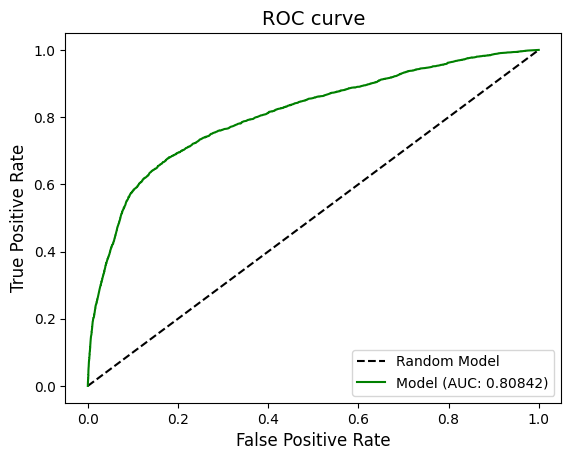

In [43]:
y_pred = scorecard.predict_proba(x_train)[:, 1]
print(roc_auc_score(y_train, y_pred))

plot_auc_roc(y_train, y_pred)

plt.show()

0.7753977984114757


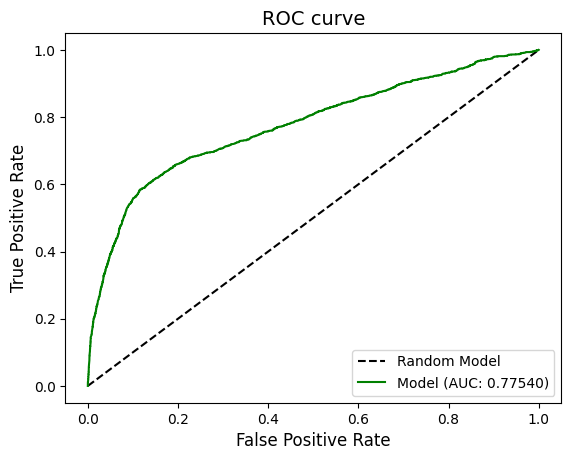

In [44]:
y_pred = scorecard.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

plot_auc_roc(y_test, y_pred)

plt.show()

<Axes: ylabel='Count'>

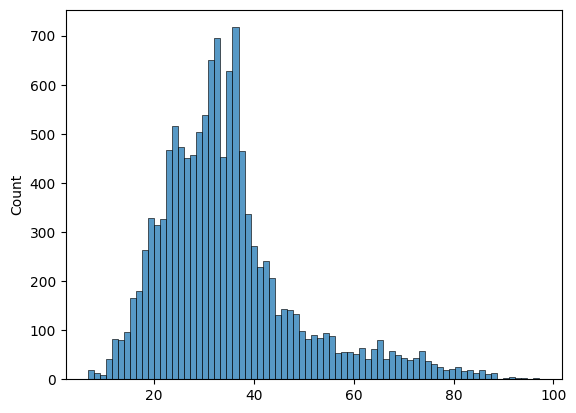

In [45]:
y_score = scorecard.score(x_test)
sns.histplot(y_score)